# Properties of Differential Privacy

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Explain the concepts of sequential composition, parallel composition, and post processing
- Calculate the cumulative privacy cost of multiple applications of a differential privacy mechanism
- Determine when the use of parallel composition is allowed
```

This chapter describes three important properties of differentially private mechanisms that arise from the definition of differential privacy. These properties will help us to design useful algorithms that satisfy differential privacy, and ensure that those algorithms provide accurate answers. 

```{important}
The three properties are:

- Sequential composition
- Parallel composition
- Post processing
```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Sequential Composition

The first major property of differential privacy is *sequential composition* {cite}`dwork2006B,dwork2006`, which bounds the total privacy cost of releasing multiple results of differentially private mechanisms on the same input data. Formally, the sequential composition theorem for differential privacy says that:

```{prf:theorem} Sequential Composition
:label: sequential-composition-def
- If $F_1(x)$ satisfies $\epsilon_1$-differential privacy
- And $F_2(x)$ satisfies $\epsilon_2$-differential privacy
- Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $\epsilon_1+\epsilon_2$-differential privacy
```

Sequential composition is a vital property of differential privacy because it enables the design of algorithms that consult the data more than once. Sequential composition is also important when multiple separate analyses are performed on a single dataset, since it allows individuals to bound the *total* privacy cost they incur by participating in all of these analyses.
The bound on privacy cost given by sequential composition is an *upper* bound - the actual privacy cost of two particular differentially private releases may be smaller than this, but never larger.

The principle that the $\epsilon$s "add up" makes sense if we examine the distribution of outputs from a mechanism which averages two differentially private results together. Let's look at some examples.

In [3]:
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2

# satisfies 1-differential privacy
def F1():
    return np.random.laplace(loc=0, scale=1/epsilon1)

# satisfies 1-differential privacy
def F2():
    return np.random.laplace(loc=0, scale=1/epsilon2)

# satisfies 2-differential privacy
def F3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)

# satisfies 2-differential privacy, by sequential composition
def F_combined():
    return (F1() + F2()) / 2

If we graph `F1` and `F2`, we see that the distributions of their outputs look pretty similar.

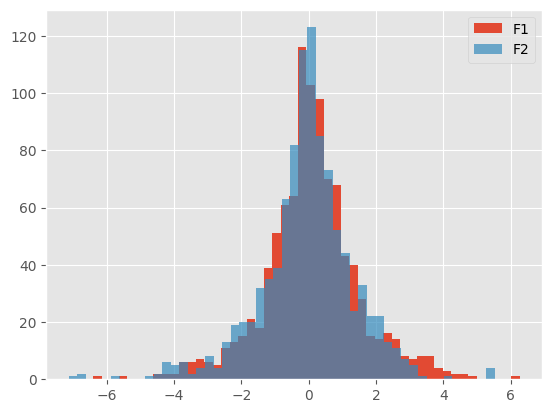

In [4]:
# plot F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# plot F2 (should look the same)
plt.hist([F2() for i in range(1000)], bins=50, alpha=.7, label='F2');
plt.legend();

If we graph `F1` and `F3`, we see that the distribution of outputs from `F3` looks "pointier" than that of `F1`, because its higher $\epsilon$ implies less privacy, and therefore a smaller likelihood of getting results far from the true answer.

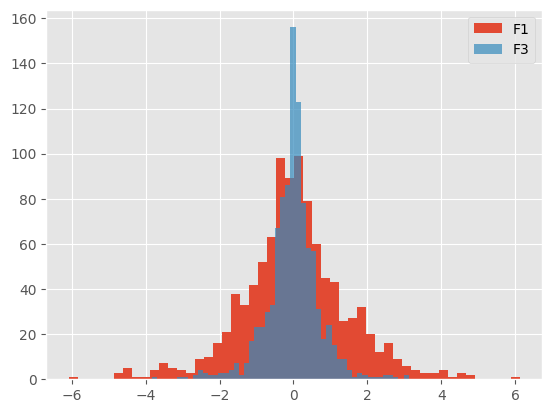

In [5]:
# plot F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# plot F3 (should look "pointier")
plt.hist([F3() for i in range(1000)], bins=50, alpha=.7, label='F3');
plt.legend();

If we graph `F1` and `F_combined`, we see that the distribution of outputs from `F_combined` is pointier. This means its answers are more accurate than those of `F1`, so it makes sense that its $\epsilon$ must be higher (i.e. it yields less privacy than `F1`).

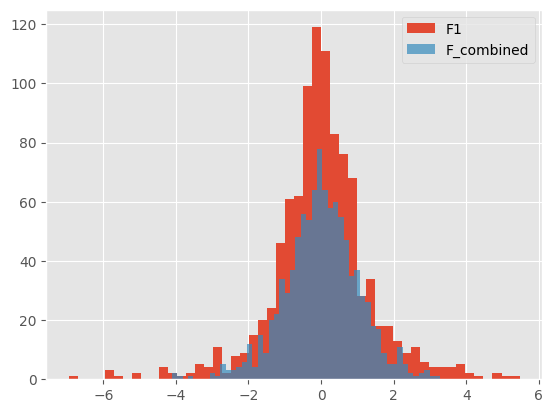

In [6]:
# plot F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# plot F_combined (should look "pointier")
plt.hist([F_combined() for i in range(1000)], bins=50, alpha=.7, label='F_combined');
plt.legend();

What about `F3` and `F_combined`? Recall that the $\epsilon$ values for these two mechanisms are the same - both have an $\epsilon$ of 2. Their output distributions should look the same.

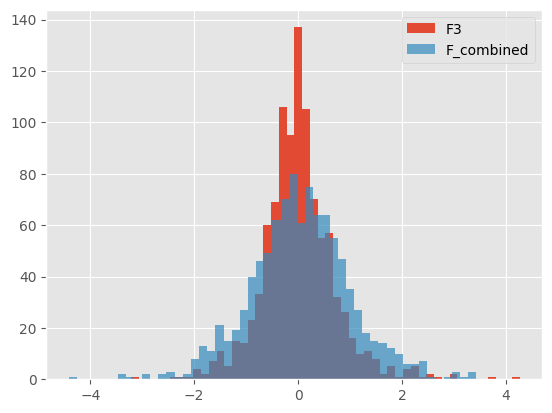

In [7]:
# plot F1
plt.hist([F3() for i in range(1000)], bins=50, label='F3');

# plot F_combined (should look "pointier")
plt.hist([F_combined() for i in range(1000)], bins=50, alpha=.7, label='F_combined');
plt.legend();

In fact, `F3` looks "pointier"! Why does this happen? Remember that sequential composition yields an *upper* bound on the total $\epsilon$ of several releases, the actual cumulative impact on privacy might be lower. That's the case here - the actual privacy loss in this case appears to be somewhat lower than the upper bound $\epsilon$ determined by sequential composition. Sequential composition is an extremely useful way to control total privacy cost, and we will see it used in many different ways, but keep in mind that it is not necessarily an exact bound.

## Parallel Composition

The second important property of differential privacy is called *parallel composition* {cite}`mcsherry2009`. Parallel composition can be seen as an alternative to sequential composition - a second way to calculate a bound on the total privacy cost of multiple data releases. Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual's data appears in *exactly* one chunk - so even if there are $k$ chunks in total (and therefore $k$ runs of the mechanism), the mechanism runs exactly once on the data of each *individual*. Formally,

```{prf:theorem} Parallel Composition
:label: parallel-composition-def
 - If $F(x)$ satisfies $\epsilon$-differential privacy
 - And we split a dataset $X$ into $k$ disjoint chunks such that $x_1 \cup ... \cup x_k = X$
 - Then the mechanism which releases all of the results $F(x_1), ..., F(x_k)$ satisfies $\epsilon$-differential privacy
``` 
 
Note that this is a much better bound than sequential composition would give. Since we run $F$ $k$ times, sequential composition would say that this procedure satisfies $k\epsilon$-differential privacy. Parallel composition allows us to say that the total privacy cost is just $\epsilon$.

The formal definition matches up with our intuition - if each participant in the dataset contributes one row to $X$, then this row will appear in *exactly* one of the chunks $x_1, ..., x_k$. That means $F$ will only "see" this participant's data *one time*, meaning a privacy cost of $\epsilon$ is appropriate for that individual. Since this property holds for all individuals, the privacy cost is $\epsilon$ for everyone.

### Histograms

In our context, a *histogram* is an analysis of a dataset which splits the dataset into "bins" based on the value of one of the data attributes, and counts the number of rows in each bin. For example, a histogram might count the number of people in the dataset who achieved a particular educational level.

In [8]:
adult = pd.read_csv("adult_with_pii.csv")
adult['Education'].value_counts().to_frame().head(5)

,count
Education,
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1383


Histograms are particularly interesting for differential privacy because they automatically satisfy parallel composition. Each "bin" in a histogram is defined by a possible value for a data attribute (for example, `'Education' == 'HS-grad'`). It's impossible for a single row to have *two* values for an attribute simultaneously, so defining the bins this way *guarantees* that they will be disjoint. Thus we have satisfied the requirements for parallel composition, and we can use a differentially private mechanism to release *all* of the bin counts with a total privacy cost of just $\epsilon$.

In [15]:
epsilon = 1

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,count
Education,
HS-grad,10501.688417
Some-college,7293.195081
Bachelors,5355.418455
Masters,1723.164569
Assoc-voc,1382.971346


### Contingency Tables

A *contingency table* or *cross tabulation* (often shortened to *crosstab*) is like a multi-dimensional histogram. It counts the frequency of rows in the dataset with particular values for more than one attribute at a time. Contingency tables are frequently used to show the relationship between two variables when analyzing data. For example, we might want to see counts based on both education level and gender:

In [16]:
pd.crosstab(adult['Education'], adult['Sex']).head(5)

Sex,Female,Male
Education,,
10th,295,638
11th,432,743
12th,144,289
1st-4th,46,122
5th-6th,84,249


Like the histogram we saw earlier, each individual in the dataset participates in exactly *one* count appearing in this table. It's impossible for any single row to have multiple values simultaneously, for any set of data attributes considered in building the contingency table. As a result, it's safe to use parallel composition here, too.

In [18]:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
ct.applymap(f).head(5)

/tmp/ipykernel_465450/797734013.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ct.applymap(f).head(5)


Sex,Female,Male
Education,,
10th,294.901402,636.899668
11th,433.276848,743.226102
12th,145.044121,287.356583
1st-4th,45.968500,120.050415
5th-6th,82.837872,249.736267


It's also possible to generate contingency tables of more than 2 variables. Consider what happens each time we add a variable, though: each of the counts tends to get smaller. Intuitively, as we split the dataset into more chunks, each chunk has fewer rows in it, so all of the counts get smaller.

These shrinking counts can have a significant affect on the accuracy of the differentially private results we calculate from them. If we think of things in terms of signal and noise, a large count represents a strong *signal* - it's unlikely to be disrupted too much by relatively weak noise (like the noise we add above), and therefore the results are likely to be useful even after the noise is added. However, a small count represents a weak *signal* - potentially *as weak* as the noise itself - and after we add the noise, we won't be able to infer anything useful from the results.

So while it may seem that parallel composition gives us something "for free" (more results for the same privacy cost), that's not really the case. Parallel composition simply moves the tradeoff between accuracy and privacy along a different axis - as we split the dataset into more chunks and release more results, each result contains a weaker signal, and so it's less accurate.

## Post-processing

The third property of differential privacy we will discuss here is called *post-processing*. The idea is simple: it's impossible to reverse the privacy protection provided by differential privacy by post-processing the data in some way. Formally:

```{prf:theorem} Post-Processing
:label: post-processing-def
- If $F(X)$ satisfies $\epsilon$-differential privacy
- Then for any (deterministic or randomized) function $g$, $g(F(X))$ satisfies $\epsilon$-differential privacy
```

The post-processing property means that it's always safe to perform arbitrary computations on the output of a differentially private mechanism - there's no danger of reversing the privacy protection the mechanism has provided. In particular, it's fine to perform post-processing that might reduce the noise or improve the signal in the mechanism's output (e.g. replacing negative results with zeros, for queries that shouldn't return negative results). In fact, many sophisticated differentially private algorithms make use of post-processing to reduce noise and improve the accuracy of their results.

The other implication of the post-processing property is that differential privacy provides resistance against privacy attacks based on auxiliary information. For example, the function $g$ might contain auxiliary information about elements of the dataset, and attempt to perform a linkage attack using this information. The post-processing property says that such an attack is limited in its effectiveness by the privacy parameter $\epsilon$, regardless of the auxiliary information contained in $g$.

```{admonition} Summary
- Sequential composition bounds the total privacy cost of releasing multiple results of differentially private mechanisms on the same input data.
- Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. 
- The post-processing property means that it’s always safe to perform arbitrary computations on the output of a differentially private mechanism.
```